# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 6
# Reg-Logistic Regression, ROC, and Data Imputation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): 109A

Import libraries:

In [119]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline

## Automated Breast Cancer Detection

In this homework, we will consider the problem of early breast cancer detection from X-ray images. Specifically, given a candidate region of interest (ROI) from an X-ray image of a patient's breast, the goal is to predict if the region corresponds to a malignant tumor (label 1) or is normal (label 0). The training and test data sets for this problem is provided in the file `hw6_dataset.csv`. Each row in these files corresponds to a ROI in a patient's X-ray, with columns 1-117 containing features computed using standard image processing algorithms. The last column contains the class label, and is based on a radiologist's opinion or a biopsy. This data was obtained from the KDD Cup 2008 challenge.

The data set contain a total of 69,098 candidate ROIs, of which only 409 are malignant, while the remaining are all normal. 

*Note*: be careful of reading/treating column names and row names in this data set.

## Question 1: Beyond Classification Accuracy


0.  Split the data set into a training set and a testing set.  The training set should be 75% of the original data set, and the testing set 25%.  Use `np.random.seed(9001)`.

1. Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. You should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation. 
    1. How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients? 
    2. Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?
    
For applications with imbalanced class labels, in this case when there are many more healthy subjects ($Y=0$) than those with cancer ($Y=1$), the classification accuracy may not be the best metric to evaluate a classifier's performance. As an alternative, we could analyze the confusion table for the classifier. 

<ol start="3">
<li> Compute the confusion table for both the fitted classifier and the classifier that predicts all 0's.</li>
<li> Using the entries of the confusion table compute the *true positive rate* and the *true negative rate* for the two classifiers. Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.</li>
<li> What is the *false positive rate* of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?</li>
</ol>
*Hint:* You may use the `metrics.confusion_matrix` function to compute the confusion matrix for a classification model.

### Code Here

In [120]:
# pick out data and let read csv know there are no headers
breastdata = pd.read_csv('hw6_dataset.csv',header = None)

In [121]:
breastdata.describe()

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
count,69098.000000,69098.000000,69098.000000,69098.000000,69098.000000,69098.000000,69098.000000,69098.000000,69098.000000,69098.000000,...,69098.000000,69098.000000,69098.000000,69098.000000,69098.000000,6.909800e+04,69098.000000,69098.000000,69098.000000,69098.000000
mean,-0.001000,-0.001319,0.000782,0.000313,-0.003161,-0.002642,0.000845,-0.000382,0.002176,0.002582,...,0.002565,-0.001242,-0.001661,0.002460,-0.000910,-6.900981e-08,-0.001279,0.000268,0.000844,0.005919
std,1.211806,1.057307,1.025779,1.033022,0.983596,0.988935,0.999774,0.998935,1.005915,1.004493,...,1.003114,0.999678,0.998775,1.003224,1.000273,9.994056e-01,1.000918,0.999318,1.024488,0.076708
min,-316.000000,-147.000000,-71.400000,-81.400000,-3.080000,-9.120000,-2.070000,-1.910000,-1.570000,-1.500000,...,-15.200000,-7.460000,-32.900000,-7.780000,-1.220000,-4.710000e+00,-5.450000,-6.340000,-23.200000,0.000000
25%,-0.064700,-0.040900,-0.253000,-0.214000,-0.569000,-0.553000,-0.532000,-0.597000,-0.711000,-0.728000,...,-0.458000,-0.491000,-0.334000,-0.520000,-0.857000,-2.470000e-01,-0.606000,-0.097875,-0.259000,0.000000
50%,0.024400,0.103000,0.095600,0.085000,-0.099200,-0.098800,0.013700,-0.075300,-0.227000,-0.235000,...,-0.102000,0.161000,0.205000,-0.269000,-0.132000,3.210000e-01,0.269000,0.326000,-0.142000,0.000000
75%,0.094200,0.176000,0.360750,0.313000,0.450000,0.434000,0.582000,0.513000,0.488000,0.498000,...,0.322000,0.559000,0.399000,0.134000,0.645000,6.450000e-01,0.801000,0.583000,0.006707,0.000000
max,1.340000,3.750000,2.030000,1.750000,28.000000,26.900000,11.200000,22.200000,16.700000,22.500000,...,13.000000,6.310000,17.000000,10.600000,17.700000,1.410000e+00,1.440000,1.420000,40.600000,1.000000


C:\Users\Shaan Desai\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


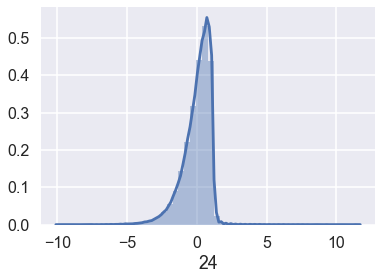

In [122]:
temp = breastdata.iloc[:,24]
sns.distplot(temp)

In [123]:
# train test split!
np.random.seed(9001)
msk = np.random.rand(len(breastdata)) < 0.75
data_train = breastdata[msk]
data_test = breastdata[~msk]

In [124]:
data_train.shape

(52009, 118)

In [125]:
# set xtrain and ytrain/xtest and ytest
X_train = data_train.iloc[:,:116]
y_train = data_train.iloc[:,117]
X_test = data_test.iloc[:,:116]
y_test = data_test.iloc[:,117]


In [126]:
# set regularization terms using xs
# uses stratified CV 
xs = np.linspace(10**(-4),10**(8),10)
lrcv = LogisticRegressionCV(Cs = xs,penalty = 'l2',fit_intercept = True)
lrcv.fit(X_train.values,np.ravel(y_train))
#

LogisticRegressionCV(Cs=array([  1.00000e-04,   1.11111e+07,   2.22222e+07,   3.33333e+07,
         4.44444e+07,   5.55556e+07,   6.66667e+07,   7.77778e+07,
         8.88889e+07,   1.00000e+08]),
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

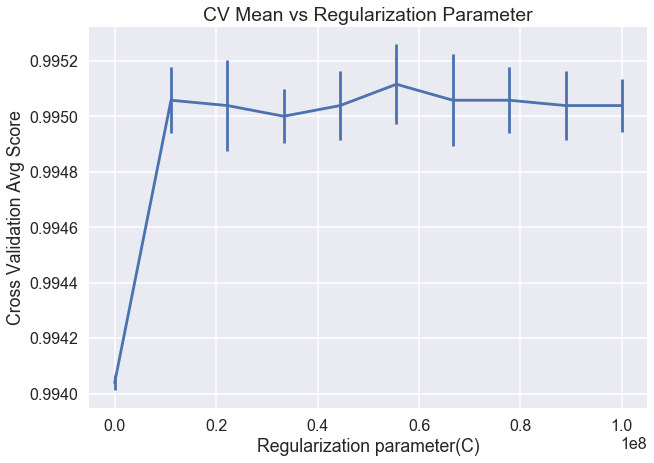

In [127]:
# plot avg cross validation score as function of Cs
cvscores = lrcv.scores_[1]
cvmean = np.mean(cvscores,axis=0)
cvstd = np.std(cvscores,axis =0)
plt.figure(figsize=(10,7))
plt.ylabel('Cross Validation Avg Score')
plt.xlabel('Regularization parameter(C)')
plt.errorbar(xs,cvmean,yerr=cvstd)
plt.title('CV Mean vs Regularization Parameter')

In [128]:
def rates(ytr,yhat,text):
    print(text)
    print('')
    model = metrics.confusion_matrix(ytr,yhat) 
    print(model)
    tn, fp, fn, tp = model.ravel()
    df = pd.DataFrame(np.c_[tp/(tp+fn),tn/(tn+fp),fp/(tn+fp),fn/(tp+fn)],columns=['TPR','TNR','FPR','FNR'])
    print('')
    print('Rates:')
    print(df)
    print('')


In [129]:
print('The training accuracy (logistic) = %s' %lrcv.score(X_train,y_train))
print('The test accuracy (logistic) = %s' %lrcv.score(X_test,y_test))
print('The training accuracy (all zero) = %s' %((52009-310)/52009))
print('The test accuracy (all zero) = %s' % ((17089-99)/17089))
rates(y_train,lrcv.predict(X_train),'Training confusion matrix using Logistic Regression:') 
rates(y_test,lrcv.predict(X_test),'Test confusion matrix using Logistic Regression:') 
rates(y_train,np.zeros(np.shape(y_train)),'Training confusion matrix using All Zero:') 
rates(y_test,np.zeros(np.shape(y_test)),'Test confusion matrix using All Zero:') 


The training accuracy (logistic) = 0.995673825684
The test accuracy (logistic) = 0.995201591667
The training accuracy (all zero) = 0.9940394931646446
The test accuracy (all zero) = 0.9942067996957107
Training confusion matrix using Logistic Regression:

[[51686    13]
 [  212    98]]

Rates:
        TPR       TNR       FPR       FNR
0  0.316129  0.999749  0.000251  0.683871

Test confusion matrix using Logistic Regression:

[[16985     5]
 [   77    22]]

Rates:
        TPR       TNR       FPR       FNR
0  0.222222  0.999706  0.000294  0.777778

Training confusion matrix using All Zero:

[[51699     0]
 [  310     0]]

Rates:
   TPR  TNR  FPR  FNR
0  0.0  1.0  0.0  1.0

Test confusion matrix using All Zero:

[[16990     0]
 [   99     0]]

Rates:
   TPR  TNR  FPR  FNR
0  0.0  1.0  0.0  1.0



#### Your answers here

Q

- How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients?

A

- A model that predicts normal on all patients has a classification accuracy of (69098-409)/(69098) = 0.994. In our model we find that the classification accuracy is slightly higher with 0.996 on the training and 0.995 on the test set. The performance seems comparable from both these models so it is not clear what we gain from logistic regression. But we will find out shortly!

Q

- Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?

A

- I do not think the classification accuracy difference is large enough since they both perform with such a high level of accuracy. Remember, we are trying to detect breast cancer so saying I can predict whether someone has breast cancer with 99.5 vs 99.4% accuracy doesn't bias me towards one model when most of the people don't have cancer. What I really care about is whether I can classify those with cancer as having it since this is the core issue at hand.

Q

- Using the entries of the confusion table compute the true positive rate and the true negative rate for the two classifiers. Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.

A

- True positive rate refers to the number of patients we predict to have breast cancer (who actually have breast cancer) / total who actually have breast cancer. The goal of this metric is to find out whether our model can predict those who indeed have the cancer. A high true positive means we are able to classify with a high level those having breast cancer(true) as actually having it(prediction)! A good metric in a situation like this one where a lot of the data suggests people do not have breast cancer on average. Notice that with the regression model, on the training set we get 0.31 and on the test we get 0.2 which suggests a low level of predictions of those that are indeed positive. However, this is significantly better than having them always be zero as the model which always predicts normal suggests.


- True negative rate refers to the number of patients we predict as not having cancer (who actually don't have cancer) / total number of patients who genuinely don't have cancer. The goal of this metric is to find out how accurately we can predict those who don't have cancer as not having cancer. (Rather tautological I understand but it makes sense). Notice that logistic regression does a great job with true negative rate of 0.9997 on both the training and test set meaning a small subset are misclassified which isn't so bad since they could simply retake the test to make sure they don't have cancer. The model which always predicts zero does phenomenally well here since it always predicts people as not having cancer but this DOES NOT HELP US find the women who do have cancer which is really not useful!


- Based off of these metrics, logistic regression is much more preferred since it actually helps us in finding our patients who have cancer. The point of this exercise is to show that using a plain accuracy score may not always be the right way to approach a problem.

Q

- What is the false positive rate of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?

A

- False positive rate = 1-true negative rate. In this situation the FPR is 0.000251455540726 on the training set and 0.00029429075927 on the test set. The reason high false positive rate is bad is that it implies true negative rate is low and that many of the people we screen are being classified as having cancer even though they don't have it. This could really be bad if it was forcing people to go into chaemotherapy if they didn't need it.

***

## Question 2: ROC Analysis

Another powerful diagnostic tool for class-imbalanced classification tasks is the Receiver Operating Characteristic (ROC) curve. Notice that the default logistic regression classifier in `sklearn` classifies a data point by thresholding the predicted class probability $\hat{P}(Y=1)$ at 0.5. By using a different threshold, we can adjust the trade-off between the true positive rate (TPR) and false positive rate (FPR) of the classifier. The ROC curve allows us to visualize this trade-off across all possible thresholds.


1. Display the ROC curve for the fitted classifier on the *test set*. In the same plot, also display the ROC curve for the all 0's classifier. How do the two curves compare?

2.  Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR.
    - FPR = 0
    - FPR = 0.1
    - FPR = 0.5
    - FPR = 0.9
- Suppose a clinician told you that diagnosing a cancer patient as normal is *twice* as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold? 

- Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)? 

*Hint:* You may use the `metrics.roc_curve` function to compute the ROC curve for a classification model and the `metrics.roc_auc_score` function to compute the AUC for the model.

### Code Here

In [130]:
#making ROC curves for this model using LAB7 code

from sklearn.metrics import roc_curve, auc
import seaborn as sns
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    # for zeros
    if clf == 1:
        fpr, tpr, thresholds=roc_curve(ytest, np.zeros(np.shape(ytest)))
    #for stuff like logistic regression
    elif proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    #for stuff like svm
    else:
        fpr, tpr, thresholds=roc_curve(ytest, )
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], '--k',alpha = 0.3,label ='ROC curve for zero pred (area = 0.5)')
        #ax.plot(0, 0,alpha = 0.3,c='r',label ='ROC curve for zero pred (area = 0)')
        ax.set_xlim([-0.1, 1.0])
        ax.set_ylim([-0.1, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax



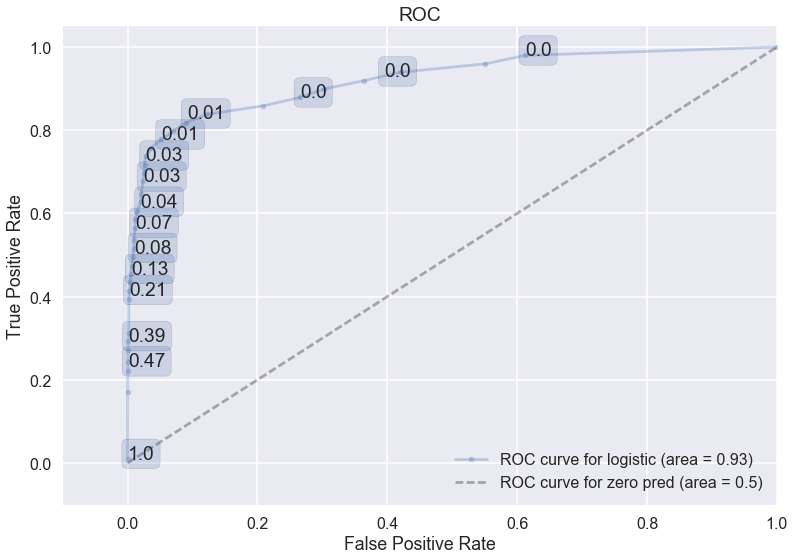

In [131]:
sns.set_context("poster")
ax=make_roc("logistic",lrcv, y_test, X_test, labe=10, skip=4)


In [132]:
fpr, tpr, thresholds=roc_curve(y_test, lrcv.predict_proba(X_test)[:,1])

In [133]:
# note that I set the third term to 0.6 since this actually will round 0.55 up
# that is the value we want since 0.55 is closest to 0.5
# note I set the last term 0.9 as having a threshold of 0
FPRlist = [0,0.1,0.6,0.9]
tprthresh = []
for i in range(len(FPRlist)):
    tempidx = np.where(np.round(fpr,1)==FPRlist[i])
    if np.shape(tempidx)[1]==0:
        tempidx = -1
    else:
        tempidx = np.amax(tempidx)
    
    tprthresh.append((tpr[tempidx],thresholds[tempidx]))

In [134]:
tprthresh = np.array(tprthresh)

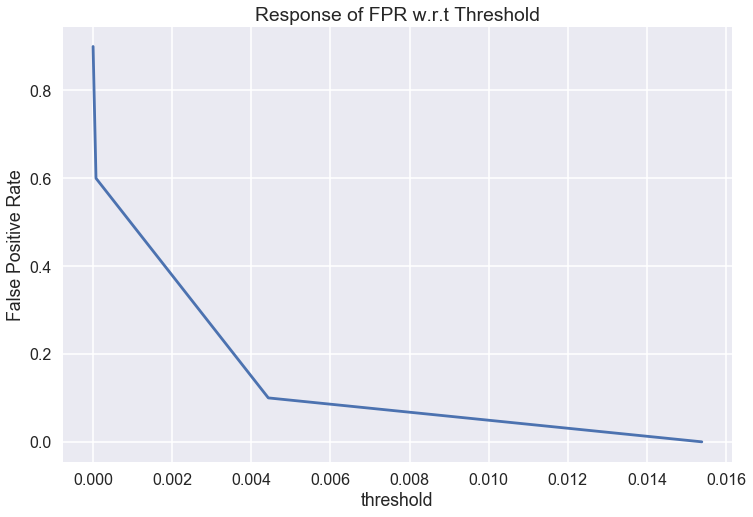

In [135]:
plt.figure(figsize=(12,8))
plt.plot(tprthresh[:,1],FPRlist)
plt.xlabel('threshold')
plt.ylabel('False Positive Rate')
plt.title('Response of FPR w.r.t Threshold')

#### Your Answer Here

Q

- Display the ROC curve for the fitted classifier on the test set. In the same plot, also display the ROC curve for the all 0's classifier. How do the two curves compare?

A

- ROC for the logistic models hugs the top left half while the all 0 predictor is simply the biased coin flip model where the bias is set by the threshold. I understand that  ROC has a curve much closer to the top left edge which is good because it means the closer we are to this edge, the better our prediction model is at determining those with cancer as having it while those without as not having it. We also notice that the threshold value changes significantly and increases the TPR drastically while maintaining a relatively low FPR for the logistic model. As for the all zero predictor, it doesn't perform better than a biased coin flip and this doesn't help us much with our problem at hand.


Q

- Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR.

A

-

In [136]:
FPRl = [0,0.1,0.5,0.9]
hightp = pd.DataFrame(np.c_[FPRl,tprthresh[:,0],tprthresh[:,1]],columns=['FPR','TPR','Threshold'])
hightp

,FPR,TPR,Threshold
0,0.0,0.777778,1.538792e-02
1,0.1,0.848485,4.429929e-03
2,0.5,0.989899,7.349650e-05
3,0.9,1.000000,2.984143e-95


- So we can see from the figure above as well as the table above that small changes in the threshold can drastically influence the FPR, particularly if we are trying to maximize the TPR at each instance. This indicates to us that we need to be careful in selecting our threshold since it significantly impacts the FPR. Why is this important? It is important because while we want a high TPR, keeping FPR low is also crucial otherwise we run into the issue of many 'false alarms' which would mean a lot of people who don't have cancer may end up going through treatment they didn't need in the first place. Such complications could cost the clinicians a lot if they're charged for damages.

Q

- Suppose a clinician told you that diagnosing a cancer patient as normal is twice as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold?

A

- What we are saying here is that the False negative rate = 2* false positive rate. Therefore given that false negative rate is 1-true positive rate we get:

$$ TPR = 1-2FPR $$

    If we draw this line on our ROC graph and see where it intersects our ROC curve for the logistic model, we will have our solution.
   
    The 0.007 threshold seems like the best for this by visual inspection. This is also justified by looking at the table above and saying 1-2*(0.1) =0.8 which is only satisfied by the second row where the threshold is 0.004 (very close to our visual inspection).

    At this threshold:
    TPR 0.82
    FPR 0.09

    This condition allows us to ensure we have a relatively high TPR while maintaining a low FPR which is good.

Q

- Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)?

A

- AUC of the logistic model is 0.93 whereas AUC for always zero model is 0.5. In comparison to Q1.2A in which the accuracy difference is on the order of $10^{-3}$ we can see that AUC is a better metric in evaluating this type of problem since it gives us a much better sense of accuracy with regards to the two models. AUC can truly help us say with confidence that the logistic model is better than the always zero model since the AUC of logistic is almost twice that of all zero.

***

## Question 3: Missing data

In this problem you are given a different data set, `hw6_dataset_missing.csv`, that is  similar to the one you used above (same column definitions and same conditions), however this data set contains missing values. 

*Note*: be careful of reading/treating column names and row names in this data set as well, it *may* be different than the first data set.


1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the regularized logistic regression as in Question 1 (use `LogisticRegressionCV` again to retune).  Report the overall classification rate and TPR in the test set.
2. Restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via mean imputation.  Split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
3. Again restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via a model-based imputation method. Once again split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
4. Compare the results in the 3 previous parts of this problem.  Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods, and conjecture and explain why you get the results that you see.



#### Model 1

In [137]:
# headers defined, drop first column since its a set of indices
data_missing = pd.read_csv('hw6_dataset_missing.csv',index_col =0)

In [138]:
data_missing.describe()

,1,2,3,4,5,6,7,8,9,10,...,109,110,111,112,113,114,115,116,117,type
count,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,...,21085.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000
mean,0.002289,0.007391,-0.000162,0.003078,0.006176,0.004787,-0.002727,-0.000678,-0.006298,-0.007603,...,-0.008844,0.003808,-0.002178,-0.006409,0.000272,0.003338,0.005499,0.003023,0.003306,0.006440
std,0.179958,0.317697,0.896449,0.771801,1.014122,0.997451,1.001580,1.006237,0.977132,0.979436,...,0.976922,1.000087,1.011648,0.990688,1.003846,0.998341,0.996676,1.000500,0.989882,0.079994
min,-14.700000,-6.690000,-63.800000,-54.800000,-3.080000,-2.990000,-2.050000,-1.660000,-1.570000,-1.500000,...,-6.930000,-5.410000,-14.800000,-4.860000,-1.220000,-4.510000,-5.600000,-5.880000,-14.800000,0.000000
25%,-0.065150,-0.040600,-0.264000,-0.223000,-0.562000,-0.548000,-0.523000,-0.593000,-0.713000,-0.727000,...,-0.459000,-0.488000,-0.349000,-0.524000,-0.847000,-0.252000,-0.588000,-0.096000,-0.258000,0.000000
50%,0.024100,0.103000,0.089100,0.080400,-0.097900,-0.097400,0.005660,-0.089400,-0.221000,-0.238000,...,-0.104000,0.161000,0.204000,-0.266000,-0.137000,0.322000,0.274000,0.327000,-0.141000,0.000000
75%,0.094200,0.175000,0.359000,0.313000,0.454000,0.437000,0.563000,0.513000,0.484500,0.493000,...,0.322000,0.568000,0.399000,0.128000,0.652000,0.647000,0.807000,0.587000,0.005810,0.000000
max,0.954000,5.430000,1.990000,1.720000,44.400000,32.800000,15.200000,19.500000,13.300000,11.600000,...,11.200000,6.310000,9.400000,11.600000,16.900000,1.330000,1.380000,1.360000,26.900000,1.000000


In [139]:
# drop rows with nan's
data_missing = data_missing.dropna(how='any')

In [140]:
data_missing.shape

(1436, 118)

In [141]:
# train test split!
np.random.seed(9000)
msk = np.random.rand(len(data_missing)) < 0.75
data_train = data_missing[msk]
data_test = data_missing[~msk]

In [142]:
# set xtrain and ytrain/xtest and ytest
X_train = data_train.iloc[:,:116]
y_train = data_train.iloc[:,117]
X_test = data_test.iloc[:,:116]
y_test = data_test.iloc[:,117]

In [143]:
np.shape(y_train[y_train==1])

(2,)

In [144]:
# set regularization terms using xs
# uses stratified CV 
# need to set CV = 2 to avoid errors
xs = np.linspace(10**(-4),10**(8),10)
lrcv = LogisticRegressionCV(Cs = xs,penalty = 'l2',cv = 2,fit_intercept = True)
lrcv.fit(X_train.values,np.ravel(y_train))
print('The training accuracy = %s' %lrcv.score(X_train,y_train))
print('The test accuracy = %s' %lrcv.score(X_test,y_test))
rates(y_test,lrcv.predict(X_test),'Test Matrix (model 1)')

The training accuracy = 0.998148148148
The test accuracy = 0.997191011236
Test Matrix (model 1)

[[355   0]
 [  1   0]]

Rates:
   TPR  TNR  FPR  FNR
0  0.0  1.0  0.0  1.0



___


#### Model 2

In [145]:
# headers defined, drop first column since its a set of indices
data_missing = pd.read_csv('hw6_dataset_missing.csv',index_col =0)

In [146]:
data_missing = data_missing.fillna(data_missing.mean())

In [147]:
# train test split!
np.random.seed(9001)
msk = np.random.rand(len(data_missing)) <= 0.75
data_train = data_missing[msk]
data_test = data_missing[~msk]

In [148]:
# set xtrain and ytrain/xtest and ytest
X_train = data_train.iloc[:,:116]
y_train = data_train.iloc[:,117]
X_test = data_test.iloc[:,:116]
y_test = data_test.iloc[:,117]

In [149]:
np.shape(y_train[y_train==1])

(110,)

In [150]:
# set regularization terms using xs
# uses stratified CV 
# need to set CV = 2 to avoid errors
xs = np.linspace(10**(-4),10**(8),10)
lrcv = LogisticRegressionCV(Cs = xs,penalty = 'l2',fit_intercept = True)
lrcv.fit(X_train.values,np.ravel(y_train))
print('The training accuracy = %s' %lrcv.score(X_train,y_train))
print('The test accuracy = %s' %lrcv.score(X_test,y_test))
rates(y_test,lrcv.predict(X_test),'Test Matrix (Model 2)')


The training accuracy = 0.995602416022
The test accuracy = 0.992163265306
Test Matrix (Model 2)

[[6066    8]
 [  40   11]]

Rates:
        TPR       TNR       FPR       FNR
0  0.215686  0.998683  0.001317  0.784314



 ***** 

#### Model 3

In [151]:
# headers defined, drop first column since its a set of indices
data_missing = pd.read_csv('hw6_dataset_missing.csv',index_col =0)

In [152]:
# find columns where nan values are
idx = np.where(pd.isnull(data_missing).sum() > 0)

In [153]:
# find non missing data
Xnonnull = data_missing.dropna(axis=1,how='any')
X_train = Xnonnull.drop('type',axis=1)


In [154]:
# fit model to complete predictors and predict nan observartion using predictors
linreg = LinearRegression(fit_intercept=True)
for i in range(np.shape(idx)[1]):
    # fit to rows with observations
    inds = data_missing.iloc[:,idx[0][i]].isnull()
    mdrops = np.where(inds==True)
    xtr = X_train.drop(X_train.index[mdrops])
    ytr = data_missing.iloc[:,idx[0][i]]
    ytr = ytr.drop(ytr.index[mdrops])
    linreg.fit(xtr,ytr)

    # predict on rows with nulls
    xtst = X_train.values[mdrops]
    ypred = linreg.predict(xtst)
    data_missing.iloc[:,idx[0][i]].values[mdrops] = ypred 

In [155]:
# train test split!
np.random.seed(9001)
msk = np.random.rand(len(data_missing)) < 0.75
data_train = data_missing[msk]
data_test = data_missing[~msk]

In [156]:
# set xtrain and ytrain/xtest and ytest
X_train = data_train.iloc[:,:116]
y_train = data_train.iloc[:,117]
X_test = data_test.iloc[:,:116]
y_test = data_test.iloc[:,117]

In [157]:
# set regularization terms using xs
# uses stratified CV 
# need to set CV = 2 to avoid errors
xs = np.linspace(10**(-4),10**(8),10)
lrcv = LogisticRegressionCV(Cs = xs,penalty = 'l2',fit_intercept = True)
lrcv.fit(X_train.values,np.ravel(y_train))
print('The training accuracy = %s' %lrcv.score(X_train,y_train))
print('The test accuracy = %s' %lrcv.score(X_test,y_test))
rates(y_test,lrcv.predict(X_test),'Test Matrix (Model 3)')

The training accuracy = 0.995496450143
The test accuracy = 0.992163265306
Test Matrix (Model 3)

[[6066    8]
 [  40   11]]

Rates:
        TPR       TNR       FPR       FNR
0  0.215686  0.998683  0.001317  0.784314



### Your Answers Here

Q 1 -3, see the output prints above. I have separated each question with a horizontal line and printed accuracy as well as the TPR.

Q4

- Compare the results in the 3 previous parts of this problem. Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods, and conjecture and explain why you get the results that you see.




A

- The three models perform with a high level of training/test accuracy with model 1 performing slightly better than mean/model imputation (~.997 vs 0.992 on the test sets). However, while model 1 does well to classify, it doesn't have many data points that are positive (since they're dropped) to learn from so suffers in TPR predictions(=0 for this model). In using mean imputation and model imputation, we can 'keep' more observations which allow us to develop better models that can generate a higher TPR. Model one is the least computationally expensive since it is a search over an N X N matrix to find and drop rows. Mean imputation is slightly more expensive since it involves having to find the columns with nan's, computing the mean of multiple observations and then feeding those means back in. The last model is the most expensive since it involves having to find the columns with missing data, train multiple models to fit to the features with missing data and then predict the missing values and insert them. Some conjectures are that dropping rows reduces training data drastically which means that for a situation where there are already only a few samples that are 1's, the model won't be good at predicting TPR. Mean imputation and model imputation generate the same TPR potentially because the model fitting process yields predictions that are close to the mean of the data. 